In [1]:
!pip install underthesea

     |████████████████████████████████| 7.5MB 4.4MB/s 
     |████████████████████████████████| 245kB 35.1MB/s 
     |████████████████████████████████| 753.2MB 22kB/s 
     |████████████████████████████████| 1.3MB 35.7MB/s 
     |████████████████████████████████| 747kB 30.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 901kB 27.0MB/s 
     |████████████████████████████████| 2.9MB 22.0MB/s 
     |████████████████████████████████| 1.1MB 25.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=e12bc8f37357980e4839db7cf5ba3142822abf8fe070231056fe5946ddde3c9e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.5.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.1 which is incompatib

# Khai báo các thư viện

In [2]:
import pandas as pd
from underthesea import word_tokenize
import regex
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf 
from keras_preprocessing import sequence
from keras.models import  Sequential,load_model
from keras.layers import Dense,Embedding,Flatten,GRU,SimpleRNN
from keras.layers import LSTM,Dropout,MaxPool1D,Convolution2D,GlobalMaxPooling1D,Bidirectional
from keras.datasets import imdb
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Load lữ liệu

In [3]:
data = pd.read_excel('/content/drive/MyDrive/NLP/nlp1.xlsx')
data

,Label,Data
0,6,rất đáng ghé thử vào đây đi sinh nhật bạn thấy...
1,7,vệ sinh dơ
2,5,giá cả phải chăng
3,5,giá khá rẻ
4,3,bánh bông lan phô mai mềm béo xốp nhưng vị ngọ...
...,...,...
20928,1,nay buổi chiều thèm ăn nem chua rán nên lại gh...
20929,3,gà chả lạp sườn cũng ngon
20930,0,giá hơi cao 1 đĩa nem này hơn 90 nghìn
20931,1,thôi thì bỏ qua vì đồ ăn quá ư là ưng ý


In [4]:
# các nhãn
set(data['Label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Xử lí câu

In [5]:
# hàm xử lí câu
def xuli(cau):
  cau = regex.sub('[.,;/!?#“”$%()^&*-@+=]',' ',cau)
  cau = cau.lower()
  cau = word_tokenize(cau,format='text')
  cau = cau.strip()
  return cau

In [6]:
for i in range(len(data)):
  data['Data'][i] = xuli(data['Data'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Đếm số lần xuất hiện mỗi từ và visualize

In [7]:
# Đếm số lần xuất hiện của các từ
count ={}
for i in data['Data']:
  for j in i.split():
    count[j] = count.get(j,0)+1
    

In [10]:
# sắp xếp giảm dần theo value
count = dict(sorted(count.items(), key = lambda x: x[1],reverse=True))

In [11]:
# Visuallize  
import plotly.graph_objects as go
key = [i for i in count]
value = [count[i] for i in count]
fig = go.Figure(data = [go.Bar(x=key[:50],y=value[:50],text=value[:50])])
fig.update_xaxes(tickangle=40)
fig.show()

# Loại bỏ Stopword theo tần số xuất hiện

In [12]:
# Xây dựng stopword là các từ xuất hiện < 3
stopword = [] 
for i in count:
  if count[i]<3:
    stopword.append(i)
len(stopword)

2970

In [13]:
# Loại bỏ stopword khỏi data
for i in range(len(data)):
  s =''
  cau = data['Data'][i].split()
  for j in cau:
    if j not in stopword:
      s+= j+' '
  s = s.strip()
  data['Data'][i] = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Xây dựng từ điển

In [14]:
# tạo vocab
vocab = []
for i in data['Data']:
  for j in i.split():
    if j not in vocab:
      vocab.append(j)
len(vocab)

3225

In [15]:
# tạo từ điển
word_id = {}
id_word = {}
dem = 1
for i in vocab:
  word_id[i] = dem
  id_word[dem]=i
  dem+=1

In [16]:
len(id_word)

3225

In [ ]:
# import json 
# with open("/content/drive/MyDrive/NLP/model/word_id.json", "w") as outfile: 
#     json.dump(word_id, outfile)

In [17]:
# Hàm chuyển câu thành số
def chuyenCauThanhSo(cau):
  arr = []
  for i in cau.split():
    arr.append(word_id[i])
  return arr

# Tìm câu dài nhất

In [18]:
# tìm câu dài nhất
max_len = 1
for i in data['Data']:
  a = len(i.split())
  if a > max_len:
    max_len = a
max_len

117

# Xây dụng data train model embedding

In [19]:
# tạo data train embedding
word_embedding = []
for i in data['Data']:
    word_embedding.append(i.split())

In [20]:
print(word_embedding[0])

['rất', 'đáng', 'ghé', 'thử', 'vào', 'đây', 'đi', 'sinh_nhật', 'bạn', 'thấy', 'quán', 'này', 'củng', 'được', 'đây', 'chứ', 'không_gian', 'sân', 'vườn', 'thoáng', 'và', 'đẹp', 'nữa']


# Train model embedding

In [21]:
# model embedding
model_skip = Word2Vec(word_embedding,window=2,min_count=1,size=300)
# model_skip.save('/content/drive/MyDrive/NLP/model/model_skip_300.model')

In [22]:

model_skip.most_similar('tệ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('ok', 0.9302281141281128),
 ('chán', 0.9160946011543274),
 ('tốt', 0.9128738641738892),
 ('đơ', 0.907355546951294),
 ('hài_lòng', 0.9031915068626404),
 ('cởi_mở', 0.9028476476669312),
 ('phải_chăng', 0.8927072882652283),
 ('chậm', 0.8872870206832886),
 ('kém', 0.8851527571678162),
 ('ổn', 0.8817865252494812)]

In [23]:
model_skip.wv['ngon'].shape

(300,)

# Load model embedding và visuallize các từ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



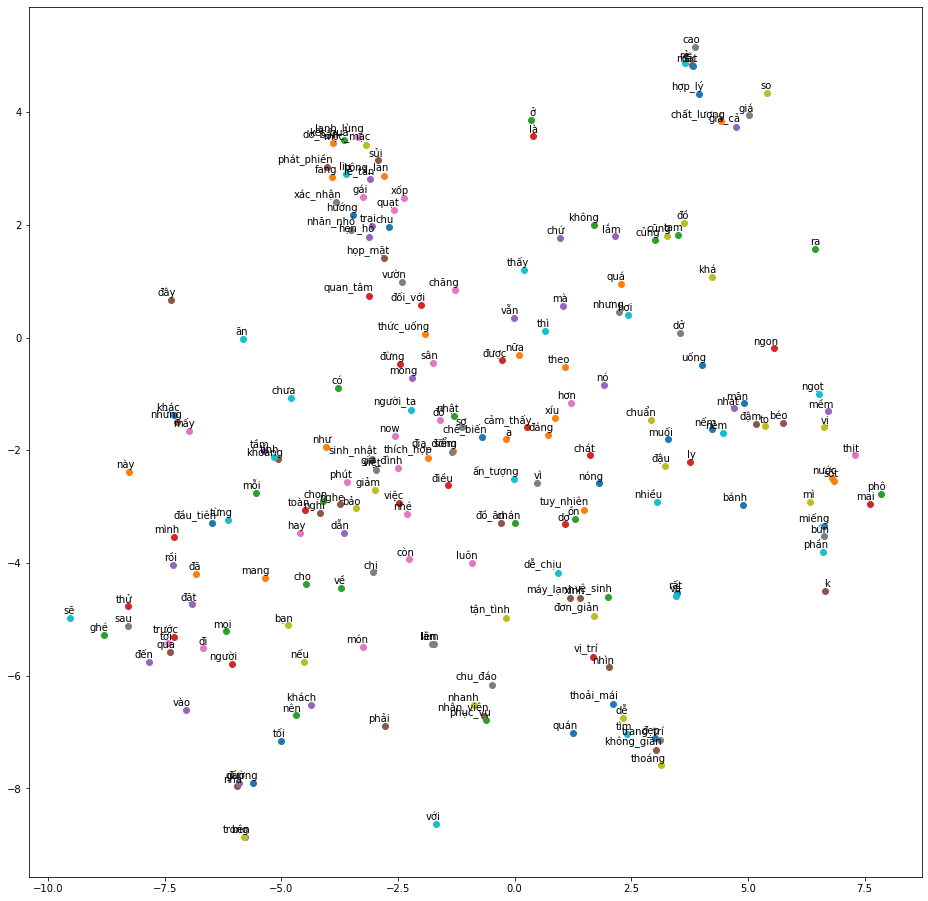

In [25]:
# load model embedding
model_skip = Word2Vec.load('/content/drive/MyDrive/NLP/model/model_skip_300.model')


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.vocab.keys())[0:200]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model_skip)

# Tạo matrix embedding

In [26]:
# Tạo matrix embedding_matrix chuẩn bị train
embedding_matrix = np.zeros((len(vocab)+1, 300))

for k, v in id_word.items():
    embedding_matrix[k] = model_skip.wv[v]
embedding_matrix.shape

(3226, 300)

# Chuyển data thành số

In [27]:
# chuyển câu thành số
x = []
for i in data['Data']:
  number = chuyenCauThanhSo(i)
  x.append(number)
len(x)

20933

# Padding câu

In [28]:
# padding câu
x = pad_sequences(x,maxlen=max_len,padding='post')

# One hot nhãn

In [29]:
# one hot nhãn
y = [i for i in data['Label']]
y =tf.keras.utils.to_categorical(y,num_classes=10)

# Chia tập train và test

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Mô hình 1

In [55]:
model = Sequential()
model.add(Embedding(len(vocab)+1, 300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
print(model.summary())
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 117, 300)          967800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 1,196,354
Trainable params: 228,554
Non-trainable params: 967,800
_________________________________________________________________
None


In [ ]:
train = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test,y_test))

Epoch 1/30
120/120 [==============================] - 66s 528ms/step - loss: 1.4493 - acc: 0.4915 - val_loss: 0.9195 - val_acc: 0.6624
Epoch 2/30
120/120 [==============================] - 62s 518ms/step - loss: 0.8836 - acc: 0.6885 - val_loss: 0.7535 - val_acc: 0.7342
Epoch 3/30
120/120 [==============================] - 62s 519ms/step - loss: 0.7105 - acc: 0.7533 - val_loss: 0.6649 - val_acc: 0.7715
Epoch 4/30
120/120 [==============================] - 62s 515ms/step - loss: 0.6377 - acc: 0.7824 - val_loss: 0.6246 - val_acc: 0.7884
Epoch 5/30
120/120 [==============================] - 62s 518ms/step - loss: 0.5416 - acc: 0.8150 - val_loss: 0.5753 - val_acc: 0.8009
Epoch 6/30
120/120 [==============================] - 62s 516ms/step - loss: 0.5047 - acc: 0.8283 - val_loss: 0.5560 - val_acc: 0.8140
Epoch 7/30
120/120 [==============================] - 63s 522ms/step - loss: 0.4558 - acc: 0.8419 - val_loss: 0.5242 - val_acc: 0.8218
Epoch 8/30
120/120 [==============================] - 6

In [ ]:
model.save('/content/drive/MyDrive/NLP/model/model1.h5')

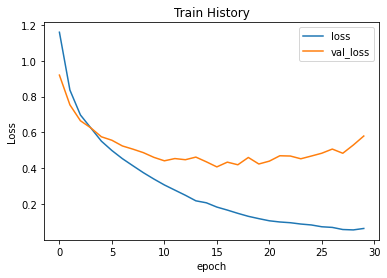

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

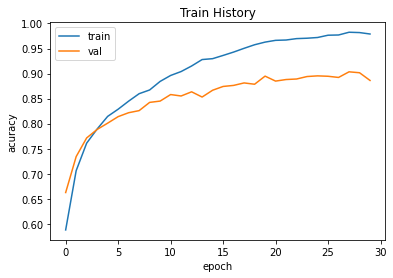

In [ ]:
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()

In [35]:
model3 = Sequential()
model3.add(Embedding(len(vocab)+1, 300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model3.add(GRU(256,return_sequences=True))
model3.add(SimpleRNN(128))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(10, activation='softmax'))
print(model3.summary())
model3.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 117, 300)          967800    
_________________________________________________________________
gru_2 (GRU)                  (None, 117, 256)          428544    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 1,454,530
Trainable params: 486,730
Non-trainable params: 967,800
________________________________________

In [ ]:
train3 = model3.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test,y_test))

Epoch 1/30
262/262 [==============================] - 205s 772ms/step - loss: 2.2128 - acc: 0.2468 - val_loss: 2.1645 - val_acc: 0.2663
Epoch 2/30
262/262 [==============================] - 201s 769ms/step - loss: 2.0763 - acc: 0.2897 - val_loss: 1.1876 - val_acc: 0.5734
Epoch 3/30
262/262 [==============================] - 201s 767ms/step - loss: 1.1221 - acc: 0.6092 - val_loss: 0.8040 - val_acc: 0.7495
Epoch 4/30
262/262 [==============================] - 201s 766ms/step - loss: 0.7593 - acc: 0.7636 - val_loss: 0.6819 - val_acc: 0.7867
Epoch 5/30
262/262 [==============================] - 200s 764ms/step - loss: 0.6636 - acc: 0.7937 - val_loss: 0.6271 - val_acc: 0.8068
Epoch 6/30
262/262 [==============================] - 200s 764ms/step - loss: 0.5856 - acc: 0.8162 - val_loss: 0.5954 - val_acc: 0.8163
Epoch 7/30
262/262 [==============================] - 200s 765ms/step - loss: 0.5296 - acc: 0.8350 - val_loss: 0.5434 - val_acc: 0.8400
Epoch 8/30
262/262 [============================

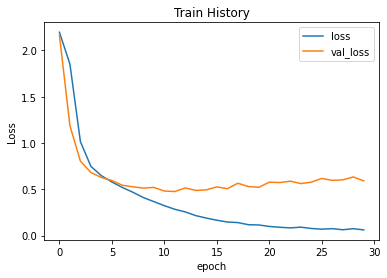

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train3.history['loss'])
plt.plot(train3.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

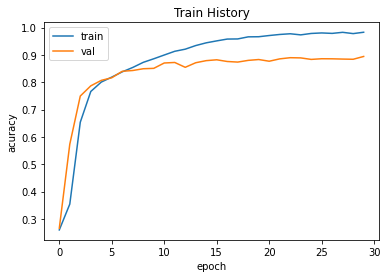

In [ ]:
plt.plot(train3.history['acc'])
plt.plot(train3.history['val_acc'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()

In [ ]:
# model3.save('/content/drive/MyDrive/NLP/model/model3.h5')

In [ ]:
model4 = Sequential()
model4.add(Embedding(len(vocab)+1, 300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model4.add(Bidirectional(LSTM(64)))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(10, activation='softmax'))
print(model4.summary())
model4.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 117, 300)          967800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 1,165,346
Trainable params: 197,546
Non-trainable params: 967,800
________________________________________

In [ ]:
train4 = model4.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test,y_test))

Epoch 1/30
131/131 [==============================] - 75s 534ms/step - loss: 1.7272 - acc: 0.4248 - val_loss: 1.0413 - val_acc: 0.6365
Epoch 2/30
131/131 [==============================] - 68s 519ms/step - loss: 0.9928 - acc: 0.6548 - val_loss: 0.8718 - val_acc: 0.7003
Epoch 3/30
131/131 [==============================] - 69s 529ms/step - loss: 0.8226 - acc: 0.7245 - val_loss: 0.7722 - val_acc: 0.7497
Epoch 4/30
131/131 [==============================] - 70s 531ms/step - loss: 0.7380 - acc: 0.7529 - val_loss: 0.7220 - val_acc: 0.7624
Epoch 5/30
131/131 [==============================] - 68s 522ms/step - loss: 0.6958 - acc: 0.7691 - val_loss: 0.6782 - val_acc: 0.7741
Epoch 6/30
131/131 [==============================] - 69s 528ms/step - loss: 0.6450 - acc: 0.7851 - val_loss: 0.6645 - val_acc: 0.7850
Epoch 7/30
131/131 [==============================] - 69s 524ms/step - loss: 0.6151 - acc: 0.7975 - val_loss: 0.6304 - val_acc: 0.7915
Epoch 8/30
131/131 [==============================] - 6

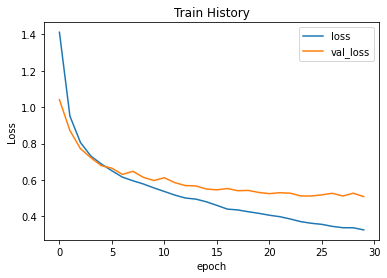

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train4.history['loss'])
plt.plot(train4.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

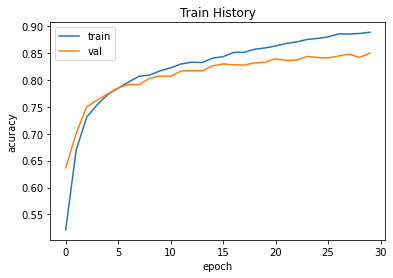

In [ ]:
plt.plot(train4.history['acc'])
plt.plot(train4.history['val_acc'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()

In [40]:
model6 = Sequential()
model6.add(Embedding(len(vocab)+1, 300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model6.add(Bidirectional(LSTM(128)))
model6.add(Dropout(0.2))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(64, activation='relu'))
model6.add(Dense(10, activation='softmax'))
model6.summary()
model6.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 117, 300)          967800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 1,448,898
Trainable params: 481,098
Non-trainable params: 967,800
________________________________________

In [41]:
train6 = model6.fit(x_train, y_train, batch_size=128, epochs=40, validation_data=(x_test,y_test))

Epoch 1/40
131/131 [==============================] - 133s 981ms/step - loss: 1.5637 - acc: 0.4468 - val_loss: 0.9487 - val_acc: 0.6637
Epoch 2/40
131/131 [==============================] - 129s 983ms/step - loss: 0.9584 - acc: 0.6618 - val_loss: 0.8022 - val_acc: 0.7316
Epoch 3/40
131/131 [==============================] - 130s 995ms/step - loss: 0.7627 - acc: 0.7462 - val_loss: 0.7004 - val_acc: 0.7626
Epoch 4/40
131/131 [==============================] - 130s 991ms/step - loss: 0.6821 - acc: 0.7753 - val_loss: 0.6466 - val_acc: 0.7901
Epoch 5/40
131/131 [==============================] - 128s 976ms/step - loss: 0.6249 - acc: 0.7908 - val_loss: 0.6430 - val_acc: 0.7862
Epoch 6/40
131/131 [==============================] - 128s 977ms/step - loss: 0.5747 - acc: 0.8062 - val_loss: 0.5838 - val_acc: 0.8061
Epoch 7/40
131/131 [==============================] - 127s 972ms/step - loss: 0.5463 - acc: 0.8178 - val_loss: 0.5725 - val_acc: 0.8180
Epoch 8/40
131/131 [============================

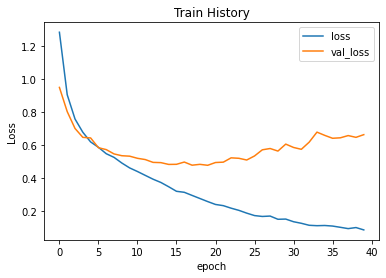

In [42]:
import matplotlib.pyplot as plt
plt.plot(train6.history['loss'])
plt.plot(train6.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

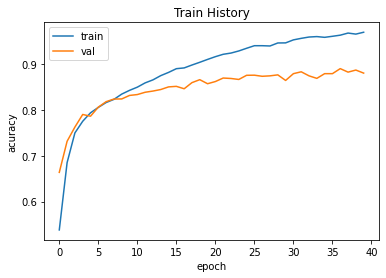

In [43]:
plt.plot(train6.history['acc'])
plt.plot(train6.history['val_acc'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()

# Mô hình SVM

## Khai báo thư viện

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn import svm,metrics

## Chia dữ liệu

In [ ]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(data['Data'],data['Label'],test_size=0.2)

In [ ]:
print(x_train1.shape)
print(x_test1.shape)

(16746,)
(4187,)


## Train mô hình embdding

In [ ]:
em = TfidfVectorizer()
em.fit(x_train1)
joblib.dump(em, '/content/drive/MyDrive/NLP/model/tfidf.pkl')


['/content/drive/MyDrive/NLP/model/tfidf.pkl']

## Cho tập train test qua model embedding

In [ ]:
x_train1 =  em.transform(x_train1)
x_test1 = em.transform(x_test1)

In [ ]:
print(x_train1[10])

  (0, 3086)	0.3712972544007523
  (0, 2984)	0.21062694854822803
  (0, 2917)	0.1033984245695899
  (0, 2815)	0.23952022366718784
  (0, 2708)	0.20212357737960956
  (0, 2704)	0.1310193300381477
  (0, 2695)	0.2955376995952315
  (0, 2488)	0.3104052025763413
  (0, 2355)	0.2689175015532992
  (0, 2270)	0.1341779357744605
  (0, 1735)	0.14803833638866024
  (0, 1603)	0.19866468993304784
  (0, 1580)	0.189694693823416
  (0, 1465)	0.2355448323872013
  (0, 1234)	0.22353438010795978
  (0, 964)	0.37854497039428997
  (0, 810)	0.1820789864268074
  (0, 383)	0.1959950855000296


## Tran model SVM

In [ ]:
model5 = svm.SVC()
model5.fit(x_train1,y_train1)
joblib.dump(model5, '/content/drive/MyDrive/NLP/model/saved_model.pkl')

['/content/drive/MyDrive/NLP/model/saved_model.pkl']

In [ ]:
print("Accuracy :", model5.score(x_test1, y_test1))

Accuracy : 0.8963458323381897


In [ ]:
pre = model5.predict(x_test1)

In [ ]:
print(metrics.classification_report(y_test1,pre))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1146
           1       0.87      0.81      0.84       576
           2       0.92      0.79      0.85       229
           3       0.88      0.83      0.85       305
           4       0.96      0.92      0.94       251
           5       0.94      0.92      0.93       336
           6       0.95      0.93      0.94       484
           7       0.96      0.99      0.97       275
           8       0.93      0.93      0.93       365
           9       0.97      0.95      0.96       220

    accuracy                           0.90      4187
   macro avg       0.92      0.90      0.91      4187
weighted avg       0.90      0.90      0.90      4187



## Predict

### Predict SVM

In [ ]:
# #predict model embedding tfidf
a = 'Bún chả ở đây ngon vừa miệng. Quán tầm buổi trưa đông khách dã man luôn. Nên là đến thì ngồi đợi 10 phút thì có đồ nha'
arr = []

for i in a.split('.'):
  a = xuli(i)
  a = np.array([a])
  a.shape
  emb = joblib.load('/content/drive/MyDrive/NLP/model/tfidf.pkl')
  em = emb.transform(a)
  model = joblib.load('/content/drive/MyDrive/NLP/model/saved_model.pkl')
  result = model.predict(em)
  arr.append(result[0])
arr

[1, 0, 0]

## Predict GRU

In [52]:
label = {
      0:'tào lao',1:'Món ngon, tuyệt vời',2:'Món tệ, dở',3:'Món bình thường, tạm ổn',4:'Giá cao',5:'Giá rẻ',6:'Không gian thoải mái ,Sạch hợp vệ sinh',7:'Không gian hẹp, mất vệ sinh',8:'Thái độ phục vụ tốt, món lên nhanh',9:'Thái đô nhân viên không tốt, món lên chậm'    
  }

In [53]:
label

{0: 'tào lao',
 1: 'Món ngon, tuyệt vời',
 2: 'Món tệ, dở',
 3: 'Món bình thường, tạm ổn',
 4: 'Giá cao',
 5: 'Giá rẻ',
 6: 'Không gian thoải mái ,Sạch hợp vệ sinh',
 7: 'Không gian hẹp, mất vệ sinh',
 8: 'Thái độ phục vụ tốt, món lên nhanh',
 9: 'Thái đô nhân viên không tốt, món lên chậm'}

In [44]:
#predict model embedding skip gram
import json
f = open('/content/drive/MyDrive/NLP/model/word_id.json',)
word_id = json.load(f)
# Closing file
f.close()

In [45]:
def chuyenCauThanhSo(cau):
  arr = []
  for i in cau.split():
    arr.append(word_id[i])
  return arr

In [50]:

def predict(model,cau):
  arr = []
  for cau in a.split('.'):
    cau = xuli(cau)
    s = ''
    for i in cau.split():
      if i in list(word_id.keys()):
        s+=i+' '
    s = s.strip()
    # print(s)
    s = chuyenCauThanhSo(s)
    if len(s)>0:
      s = pad_sequences([s],maxlen=max_len,padding='post')
      pre = model.predict(s)
      # for l in label:
      #   if l == np.argmax(pre) and np.argmax(pre)!=0:
      #     if label[l] not in arr:
      arr.append(np.argmax(pre))
  return arr


In [47]:
model6 = load_model('/content/drive/MyDrive/NLP/model/model3.h5')

In [51]:
a = 'Bún chả ở đây ngon vừa miệng. Quán tầm buổi trưa đông khách dã man luôn. Nên là đến thì ngồi đợi 10 phút thì có đồ nha'
predict(model6,a)

[1, 0, 8]